In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
from scipy.special import softmax
import random
import pickle
from datetime import datetime
from collections import Counter

from tqdm import tqdm

import gym
from gym.spaces import Discrete, Tuple

from env_mp_simple import MetaGamesSimplest
from rmax_1_batch_simplest import RmaxAgent, Memory

def discretize(number, radius):
    #[0,3,5,4,8] --> [0,3,6,3,9] for radius 3
    return np.round(np.divide(number, radius)) * radius

def Boltzmann(arr):
    #0.5 is just a temperature parameter, controls the spread of the softmax distribution
    action_value = np.zeros(arr.shape[0])
    prob = softmax(arr/0.4, 1)
    for b in range(arr.shape[0]):
        action_value[b] = np.random.choice(np.arange(arr.shape[1]), p=prob[b])
    return action_value

In [2]:
bs = 3
inner_gamma = 0         #inner game discount factor, 0 since it's a one shot game
meta_gamma = 0         #meta game discount factor
meta_alpha = 0.4          #meta game learning rate
R_max = 1
rmax_error = 0.5
meta_epi = 5000
meta_steps = 10

epsilon = 0.8
radius = 1              #radius for discretization, assuming radius>1

In [3]:
#reward tensor for plotting purposes [bs, episode, step, agents]
plot_rew = np.zeros((bs, meta_epi, meta_steps, 2))

# creating environment
env = MetaGamesSimplest(bs, meta_steps)

# creating rmax agent
memory = Memory()
rmax = RmaxAgent(R_max, bs, meta_steps, meta_gamma, inner_gamma, radius, epsilon, rmax_error)

In [4]:
for episode in tqdm(range(meta_epi)): #for each meta-episode
    #reset environment 
    #initialise meta-state and meta-action randomly
    meta_s = env.reset()
    memory.states.append(meta_s)
   
    for step in range(meta_steps):    #for each meta time step
        #--------------------------------------START OF INNER GAME--------------------------------------  
        #select our inner-action with Boltzmann sampling, oppo inner-action with epsilon greedy 
        our_action = np.argmax(rmax.Q[np.arange(bs), rmax.find_meta_index(meta_s, "s").astype(int), :], axis=1)
        
        #print("inner actions: ", our_action, oppo_action)
        #run inner game according to actions
        obs, reward, done, _ = env.step(our_action) 

        #update inner r matrix [agent, action]
        our_innerr = np.transpose(np.stack([our_action, 1-our_action]) * reward)
        #---------------------------------------END OF INNER GAME--------------------------------------
        #save reward, info for plotting              
        plot_rew[:,episode,step,0] = reward
        plot_rew[:,episode,step,1] = 1-reward

        #meta-action = action that corresponds to max Q(meta_s) = our inner Q
        meta_a = our_action 
        memory.actions.append(meta_a) 

        #meta-state = discretized inner game Q table of all agents
        new_meta_s = obs
        memory.states.append(new_meta_s)    

        #meta-reward = sum of rewards of our agent in inner game of K episodes & T timesteps
        our_REW = reward               
        memory.rewards.append(our_REW)

        #rmax update step
        rmax.update(memory, meta_s, meta_a, new_meta_s)

        #prepare meta_s for next step
        meta_s = new_meta_s


100%|███████████████████████████████████████████████████████████████████| 5000/5000 [01:06<00:00, 75.14it/s]


In [11]:
self=env
np.reshape(np.argmax(self.innerq, axis=1), (self.bs))

array([0, 1, 0])

In [12]:
# Open a file and use dump()
with open('plot_rew' + str(datetime.now()) + '.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(plot_rew, file)
    
# Open a file and use dump()
with open('memory' + str(datetime.now()) + '.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(memory, file)

# Open a file and use dump()
with open('rmax' + str(datetime.now()) + '.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(rmax, file)

# Plots

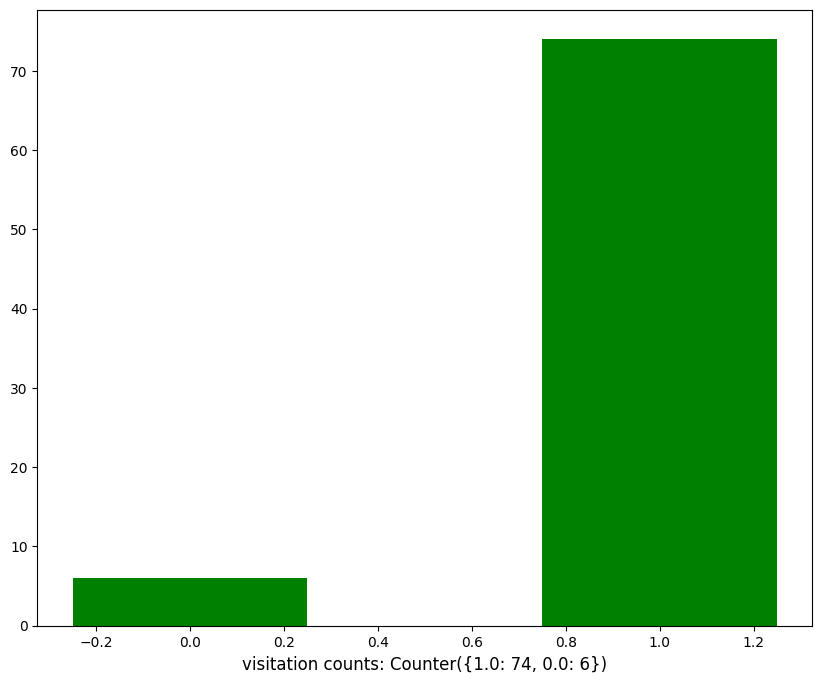

In [6]:
#generate histogram
visit_dict = {}
for i in range(len(rmax.nSA[0].flatten().tolist())):
    visit_dict[i]= rmax.nSA[0].flatten().tolist()[i]
    
histogram_dict = Counter(visit_dict.values())
plt.bar(histogram_dict.keys(), histogram_dict.values(), 0.5, color='g')
plt.xlabel("visitation counts: " + str(histogram_dict), fontsize=12)
figure0 = plt.gcf()
figure0.set_size_inches(10, 8)
#plt.savefig('histogram at' + str(datetime.now()) + '.png')

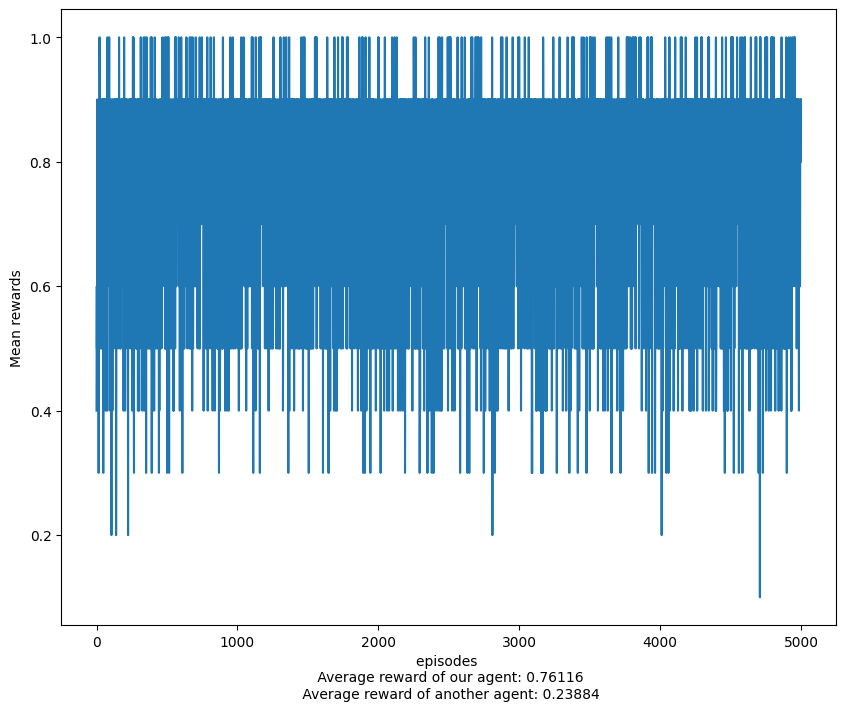

In [8]:
#generate reward mean per episode of batch 0
plot_rew_mean = np.mean(plot_rew[0,:,:,0], axis=1)
fig_handle = plt.plot(plot_rew_mean)
#reward at batch 0 only
plt.xlabel("episodes \n Average reward of our agent: " + str(np.mean(plot_rew[0,:,:,0])) + 
          "\n Average reward of another agent: " + str(np.mean(plot_rew[0,:,:,1])))

plt.ylabel("Mean rewards")

figure2 = plt.gcf() # get current figure
figure2.set_size_inches(10, 8)

#plt.savefig('inner_gamma' + str(inner_gamma) + '_rad' + str(radius) + '_' + str(meta_epi) + '_' + str(meta_steps) + '_mp1.png'  , dpi = 100)
#plt.clf()


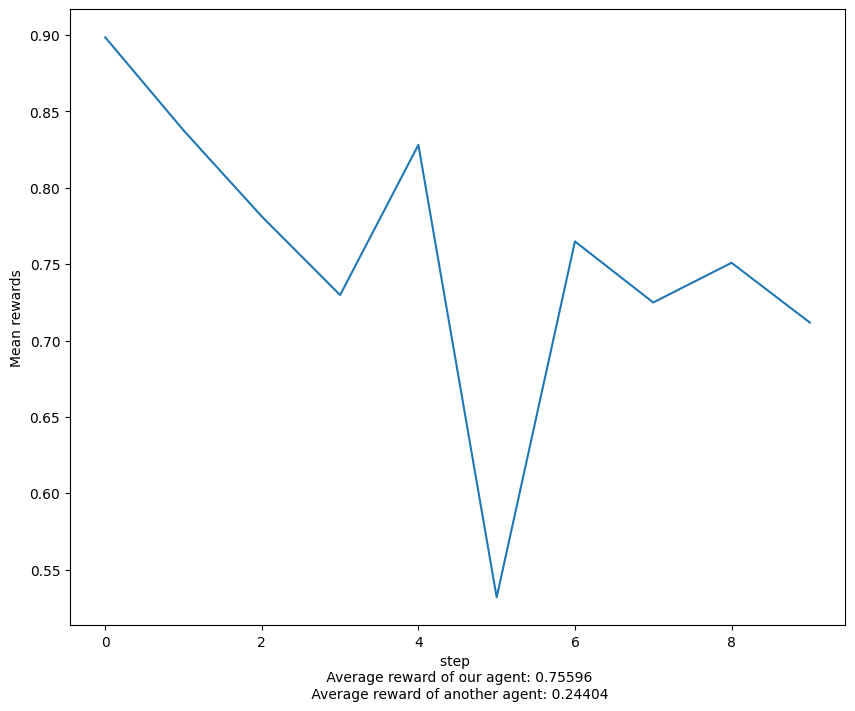

In [10]:
#generate reward mean per step of batch 0
plot_rew_mean = np.mean(plot_rew[0,:,:,0], axis=0)
fig_handle = plt.plot(plot_rew_mean)
#reward at batch 0 only
plt.xlabel("step \n Average reward of our agent: " + str(np.mean(plot_rew[0,:,:,0])) + 
          "\n Average reward of another agent: " + str(np.mean(plot_rew[0,:,:,1])))

plt.ylabel("Mean rewards")

figure2 = plt.gcf() # get current figure
figure2.set_size_inches(10, 8)

#plt.savefig('inner_gamma' + str(inner_gamma) + '_rad' + str(radius) + '_' + str(meta_epi) + '_' + str(meta_steps) + '_mp1.png'  , dpi = 100)
#plt.clf()


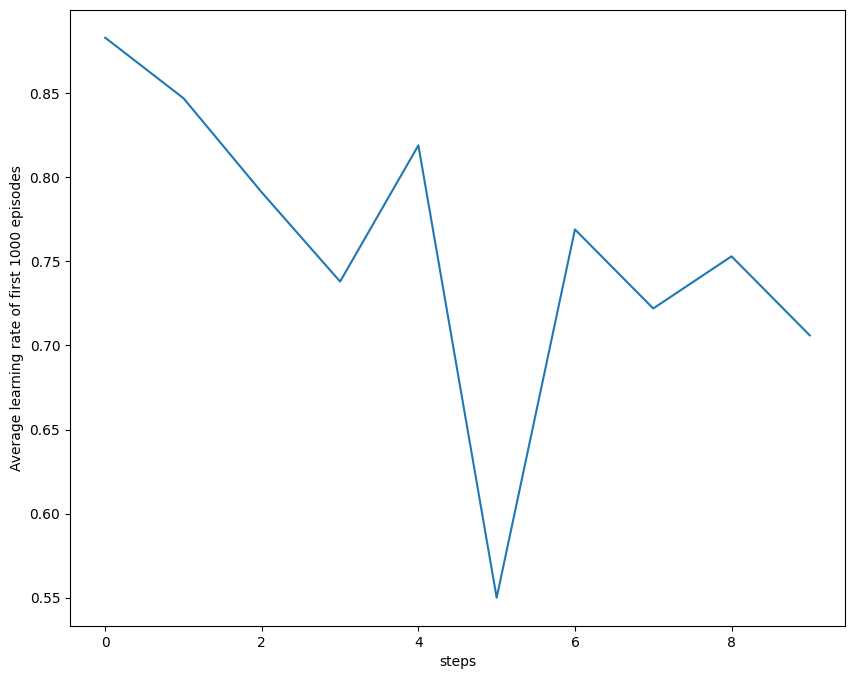

In [11]:
#generate learning curve at start of batch 0
plot_rew_epi_start = np.mean(plot_rew[0, :int(meta_epi*0.1), :, 0], axis=0)
fig_handle = plt.plot(plot_rew_epi_start)

plt.xlabel("steps")

plt.ylabel("Average learning rate of first " + str(int(meta_epi*0.1)) + " episodes")

figure3 = plt.gcf() # get current figure
figure3.set_size_inches(10, 8)

#plt.savefig('inner_gamma' + str(inner_gamma) + '_rad' + str(radius) + '_' + str(meta_epi) + '_' + str(meta_steps) + '_first_epi_mp1.png' , dpi = 100)
#plt.clf()

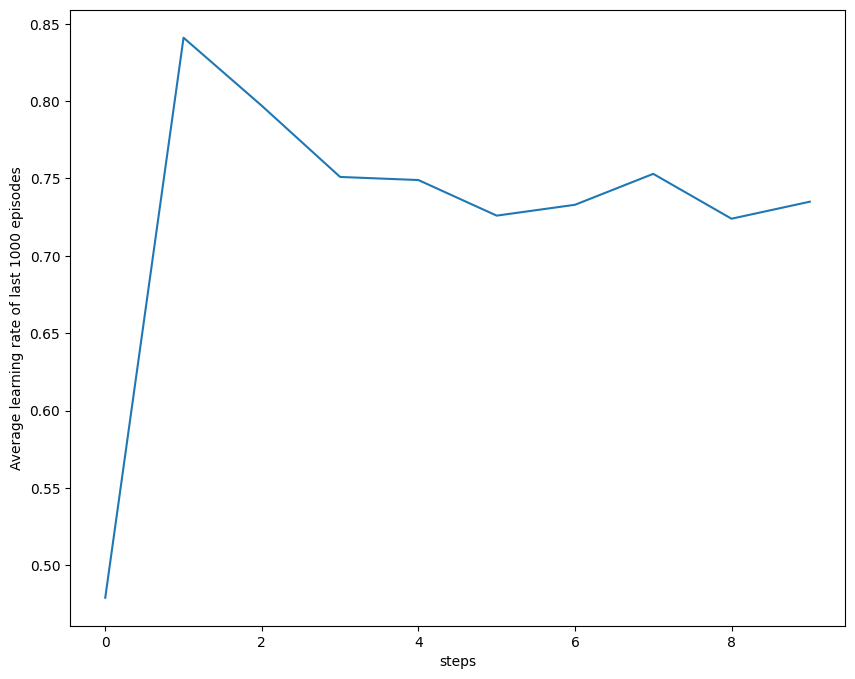

In [20]:
#generate learning curve at end
plot_rew_epi_end = np.mean(plot_rew[0, -int(meta_epi*0.1):, :, 0], axis=0)
fig_handle = plt.plot(plot_rew_epi_end)

plt.xlabel("steps")

plt.ylabel("Average learning rate of last " + str(int(meta_epi*0.1)) + " episodes")

figure4 = plt.gcf() # get current figure
figure4.set_size_inches(10, 8)

#plt.savefig('inner_gamma' + str(inner_gamma) + '_rad' + str(radius) + '_' + str(meta_epi) + '_' + str(meta_steps) + '_last_epi_mp1.png' , dpi = 100)
#plt.clf()

# Interpreting results 

In [ ]:

import glob
path1 = "memory*.pkl"
path2 = "plot_rew*.pkl"
path3 = "rmax*.pkl"
for filename in glob.glob(path1):
    with open(filename, 'rb') as f:
        memory = pickle.load(f)
        
for filename in glob.glob(path2):    
    with open(filename, 'rb') as g:
        plot_rew = pickle.load(g)
        
for filename in glob.glob(path3):    
    with open(filename, 'rb') as g:
        rmax = pickle.load(g)        